# Airport Networks


## Importing Necessary libraries

In [1]:
# libraries used
# for data analysis
import numpy as np
import pandas as pd
# running algorithms on graph networks efficiently
import networkx as nx
# for plots
import matplotlib.pyplot as plt
import seaborn as sns
# un-supervised learning through Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# Visualize Interactive Geographic Maps
import folium
from folium import Circle
# warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
df = pd.read_csv("airline_network.csv")
print("DataFrame Shape: " + str(df.shape))
df["Codeshare"] = df["Codeshare"].fillna("N")
print("DataFrame Null Value Counts by Rows:")
print(df.isnull().sum())
df.head(5)

DataFrame Shape: (67663, 9)
DataFrame Null Value Counts by Rows:
Airline                    0
Airline ID                 0
Source airport             0
Source airport ID          0
Destination airport        0
Destination airport ID     1
Codeshare                  0
Stops                      0
Equipment                 18
dtype: int64


,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,NaN,N,0,CR2
1,2B,410,ASF,2966,KZN,2990,N,0,CR2
2,2B,410,ASF,2966,MRV,2962,N,0,CR2
3,2B,410,CEK,2968,KZN,2990,N,0,CR2
4,2B,410,CEK,2968,OVB,4078,N,0,CR2


We shall extract the edges from the orginal data set and form an graph network edge dataset on pandas. Next, we can engineer Graph based Features based on importance of nodes:

    1) Degree Centrality: Measure of importamce of nodes based on their degree in a graph network. For directed graphs, we can have In-Degree Centrality and Out-Degree Centrality.
    2) Closeness Centrality: Method of identifying Nodes which are close to other nodes. Not recommended to use in this dataset distance is not known and it can play a big factor in airport distance between airports.
    3) Betweeness Centrality: Nodes that lie in the shortest path between any 2 nodes often are considered important. Betweeness Centrality is a quantification of the property.
    4) Page Rank: Used by search engines to rank websites with respect to their importance. An intuitive understanding could be that if you were to take a random walk across the nodes in a network via their connections then the page rank score gives you a sense of high likely you are to end up at that position.
    5) Hub Score: A centrality score based on the nodes ability to make relations with other nodes.
    6) Authority Score: A centrality score based on the node based on the relations made to the node.

In [3]:
df_edges = df[["Source airport", "Destination airport"]]
G = nx.from_pandas_edgelist(df_edges, "Source airport", "Destination airport", create_using=nx.MultiDiGraph())
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweeness_centrality = nx.betweenness_centrality(G)
page_rank = nx.pagerank(G, alpha=0.85)
hubs, authorities = nx.hits(G)

In [4]:
nodes_df = pd.DataFrame(pd.Series(list(G.nodes))).rename(columns={0:"Nodes"})
nodes_df["In-Degree"] = nodes_df["Nodes"].apply(lambda x: G.in_degree(x))
nodes_df["Out-Degree"] = nodes_df["Nodes"].apply(lambda x: G.out_degree(x))
nodes_df["Total Degree"] = nodes_df["In-Degree"] + nodes_df["Out-Degree"]
nodes_df["In-Degree Centrality"] = nodes_df["Nodes"].apply(lambda x: in_degree_centrality[x])
nodes_df["Out-Degree Centrality"] = nodes_df["Nodes"].apply(lambda x: out_degree_centrality[x])
nodes_df["Betweeness Centrality"] = nodes_df["Nodes"].apply(lambda x: betweeness_centrality[x])
nodes_df["Page Rank"] = nodes_df["Nodes"].apply(lambda x: page_rank[x])
nodes_df["Hub Score"] = nodes_df["Nodes"].apply(lambda x: hubs[x])
nodes_df["Authority Score"] = nodes_df["Nodes"].apply(lambda x: authorities[x])
display(nodes_df.head(5))
print(nodes_df.shape)

,Nodes,In-Degree,Out-Degree,Total Degree,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
0,AER,26,26,52,0.007593,0.007593,2.437452e-05,0.000314,0.000156,0.000144
1,KZN,28,28,56,0.008178,0.008178,4.911256e-05,0.000344,0.000145,0.000146
2,ASF,8,8,16,0.002336,0.002336,7.817094e-07,0.000130,0.000056,0.000056
3,MRV,22,22,44,0.006425,0.006425,2.958986e-05,0.000278,0.000167,0.000166
4,CEK,20,20,40,0.005841,0.005841,4.369093e-06,0.000244,0.000104,0.000104


(3425, 10)


# Analyzing Node Impoertance

,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
count,3425.000000,3425.000000,3.425000e+03,3425.000000,3.425000e+03,3.425000e+03
mean,0.005770,0.005770,8.927743e-04,0.000292,2.919708e-04,2.919708e-04
std,0.015571,0.015598,4.219605e-03,0.000553,9.099537e-04,9.084179e-04
min,0.000000,0.000000,0.000000e+00,0.000044,-4.487729e-21,-3.959912e-19
25%,0.000584,0.000584,0.000000e+00,0.000078,1.952782e-06,2.003582e-06
50%,0.001168,0.001168,1.291696e-07,0.000127,2.240678e-05,2.305360e-05
75%,0.003213,0.003213,1.371376e-04,0.000238,1.370055e-04,1.393052e-04
max,0.266063,0.267231,7.020363e-02,0.009263,1.526436e-02,1.514375e-02


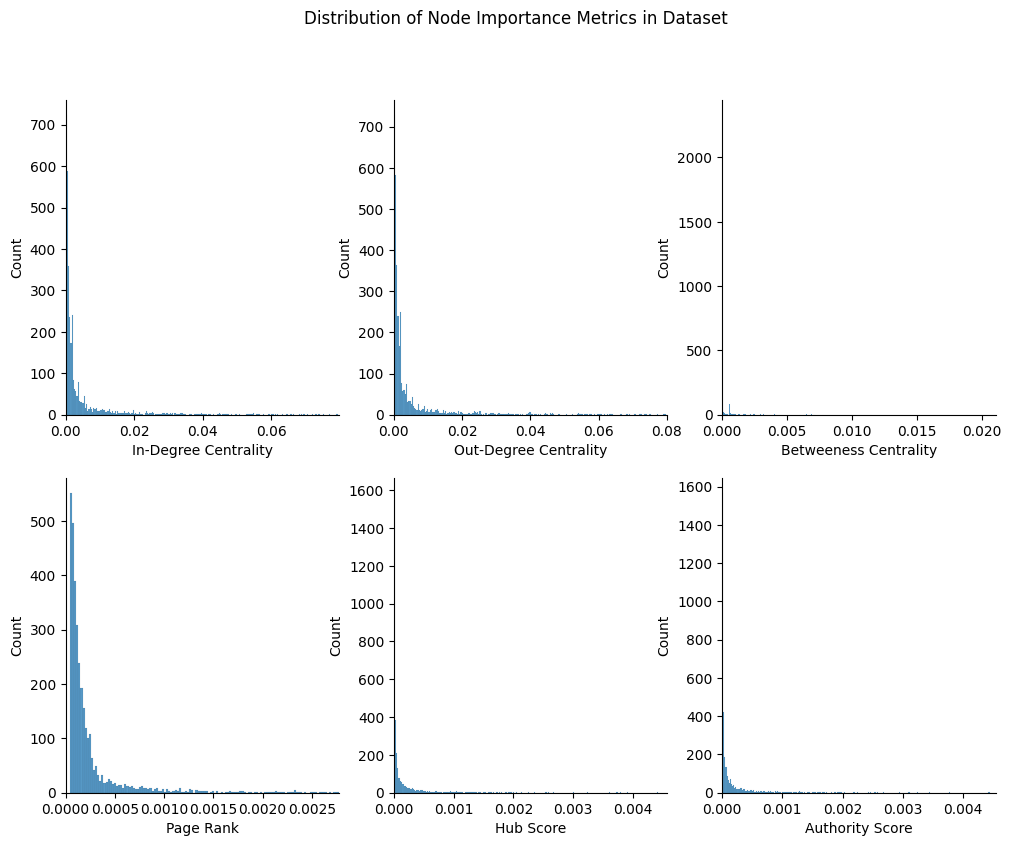

In [5]:
nodes_df_importance = nodes_df.drop(["Nodes","In-Degree","Out-Degree", "Total Degree"], axis=1)
display(nodes_df_importance.describe())
plt.subplots(nrows=2, ncols=3, figsize=(12,9))
for i in range(1,7):
    plt.subplot(2,3,i)
    sns.histplot(data=nodes_df_importance, x =nodes_df_importance.columns[i-1] )
    plt.xlim(0,0.3*np.max(nodes_df_importance[nodes_df_importance.columns[i-1]]))
    sns.despine()
plt.suptitle("Distribution of Node Importance Metrics in Dataset")
plt.show()

The distributions of all the node importance metrics seemed to be skewed towards the left. Based on the pairplot below, we can see that In-Degree and Out-Degree Centrality appear to be higly correlated and hubs and authority scores also seem to be highly correlated. A possible explanation for high correlation would be that all flights from an airport likely have return flight as well.

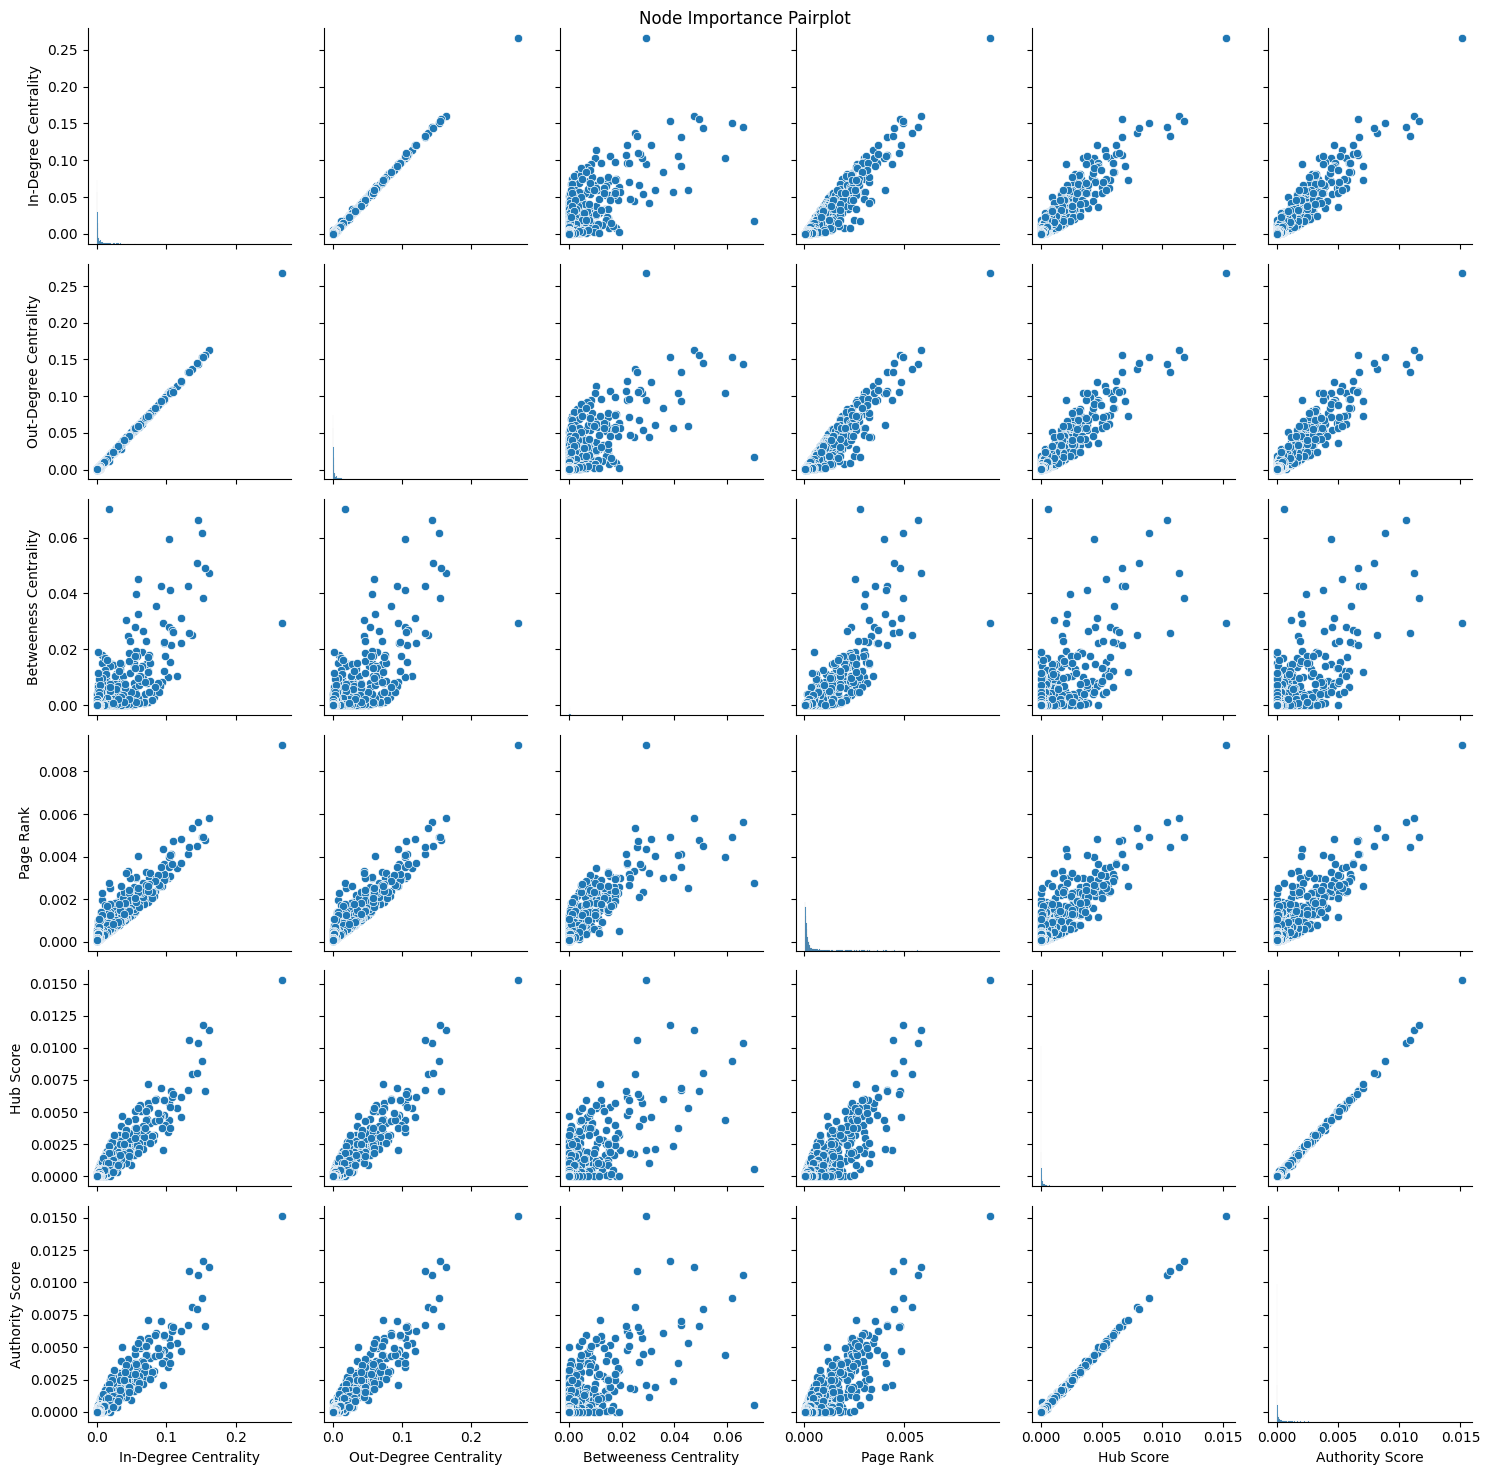

In [6]:
sns.pairplot(data=nodes_df_importance)
plt.suptitle("Node Importance Pairplot")
plt.tight_layout()
plt.show()

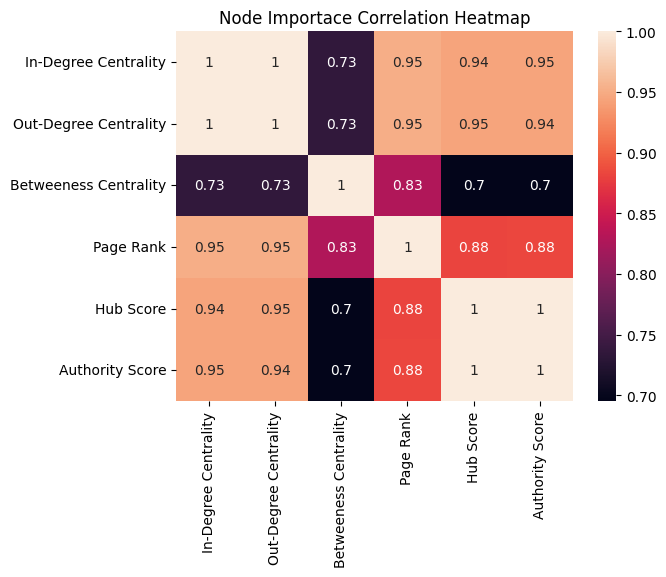

In [7]:
sns.heatmap(data=nodes_df_importance.corr(), annot=True)
plt.title("Node Importace Correlation Heatmap")
plt.show()

## k-Means Clustering

Elbow method for selecting number of clusters:

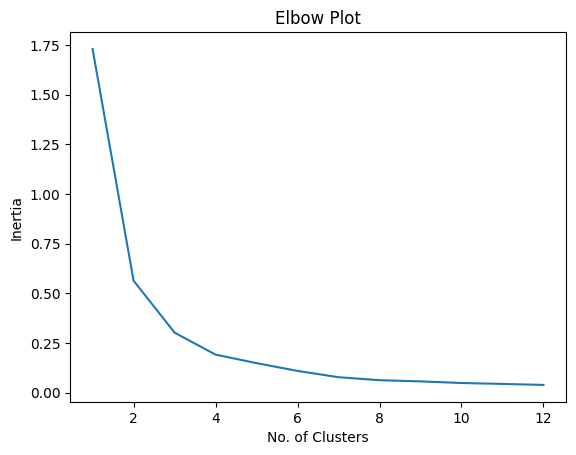

In [8]:
n = [i for i in range(1,13)]
inertia = []
for i in n:
    X = nodes_df.copy()
    X = X.drop(["In-Degree", "Out-Degree", "Total Degree"], axis=1)
    y = X.pop("Nodes")
    X_new = PCA(n_components=3).fit_transform(X)
    standardize = MinMaxScaler().fit_transform(X_new)
    kmeans = KMeans(n_clusters=i, random_state=2, n_init="auto", max_iter=1000).fit(X)
    inertia.append(kmeans.inertia_)


X = nodes_df.copy()
X = X.drop(["In-Degree", "Out-Degree", "Total Degree"], axis=1)
y = X.pop("Nodes")
X_new = PCA(n_components=3, random_state=2).fit_transform(X)
standardize = MinMaxScaler()
kmeans = KMeans(n_clusters=4, random_state=2, n_init="auto", max_iter=1000)
pipeline = Pipeline([('scaler', standardize), ("clustering", kmeans)])
pipeline.fit(X_new)
X_clusters = pipeline.predict(X_new)
X_clusters = pd.Series(X_clusters, name="Clusters")
X = pd.merge(left=X, right=X_clusters, how="inner", left_index=True, right_index=True)
X = pd.merge(left = y, right= X, how="inner", left_index=True, right_index=True)

sns.lineplot(x=n, y=inertia)
plt.xlabel("No. of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Plot")
plt.show()

Based on Elbow plot, 4 seems to be a resonable selection for number of clusters. Below we can see how the 4 clusters have been distniguished in free space.

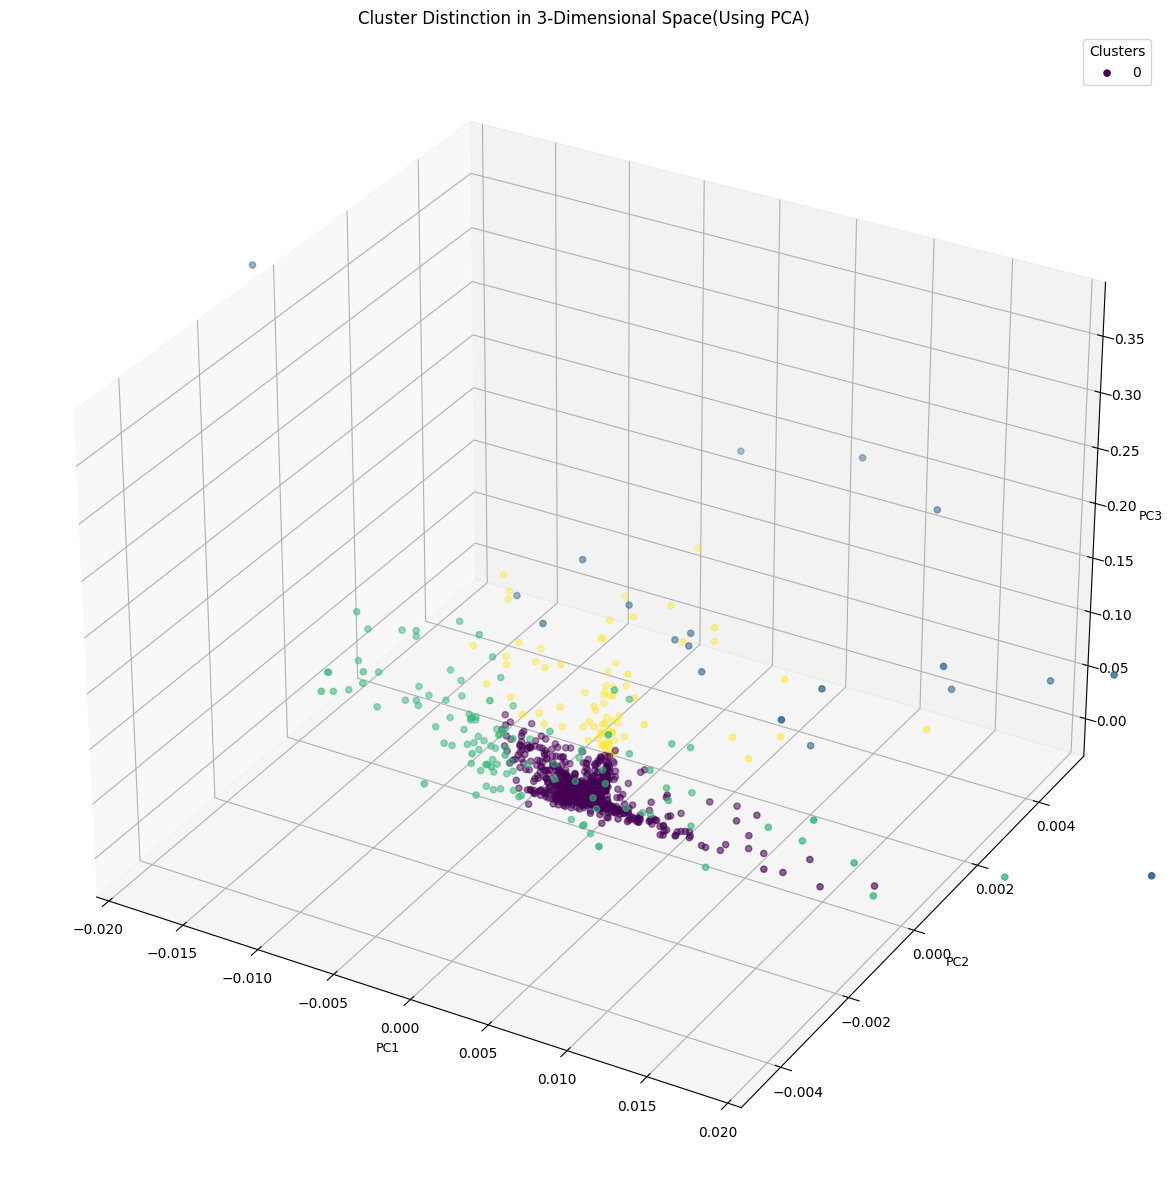

In [9]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
zdata = X_new[:,0]
xdata = X_new[:,1]
ydata = X_new[:,2]
ax.scatter3D(xdata, ydata, zdata, c=X_clusters )
ax.set_xlabel('PC1', fontsize=9)
ax.set_ylabel('PC2', fontsize=9)
ax.set_zlabel('PC3', fontsize=9)
ax.set_xlim(-0.02,0.02)
plt.title("Cluster Distinction in 3-Dimensional Space(Using PCA)")
plt.tight_layout()
ax.legend(X_clusters, title="Clusters")

plt.show()

## Cluster Distribution and Behavior

In [10]:
X.describe()

,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score,Clusters
count,3425.000000,3425.000000,3.425000e+03,3425.000000,3.425000e+03,3.425000e+03,3425.000000
mean,0.005770,0.005770,8.927743e-04,0.000292,2.919708e-04,2.919708e-04,0.142482
std,0.015571,0.015598,4.219605e-03,0.000553,9.099537e-04,9.084179e-04,0.572049
min,0.000000,0.000000,0.000000e+00,0.000044,-4.487729e-21,-3.959912e-19,0.000000
25%,0.000584,0.000584,0.000000e+00,0.000078,1.952782e-06,2.003582e-06,0.000000
50%,0.001168,0.001168,1.291696e-07,0.000127,2.240678e-05,2.305360e-05,0.000000
75%,0.003213,0.003213,1.371376e-04,0.000238,1.370055e-04,1.393052e-04,0.000000
max,0.266063,0.267231,7.020363e-02,0.009263,1.526436e-02,1.514375e-02,3.000000


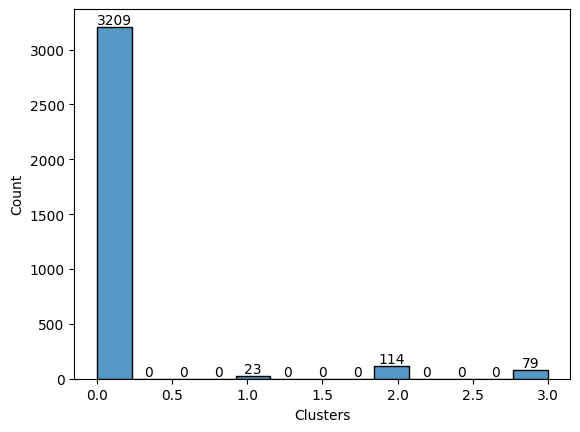

In [11]:
ax1 = sns.histplot(data=X, x="Clusters")
rects = ax1.patches
for rect in rects:
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height, str(height)[:5] , ha="center", va="bottom"
    )
plt.show()

Based on the plot below, the clusters have been classified into 4 distinct groups:

    Cluster 0: Majority of Nodes belong to this category. These nodes have a low node importance which includes most airports in this dataset.

    Cluster 1: This cluster seems to contain extremely important airports having averge value of all metrics greater than other nodes.

    Cluster 2: Majority of datapoints in this cluster seem to have higher value for most metrics than cluster 3.
    
    Cluster 3: It's Hub and Authority Scores seem to be higher than that of cluster 3. 

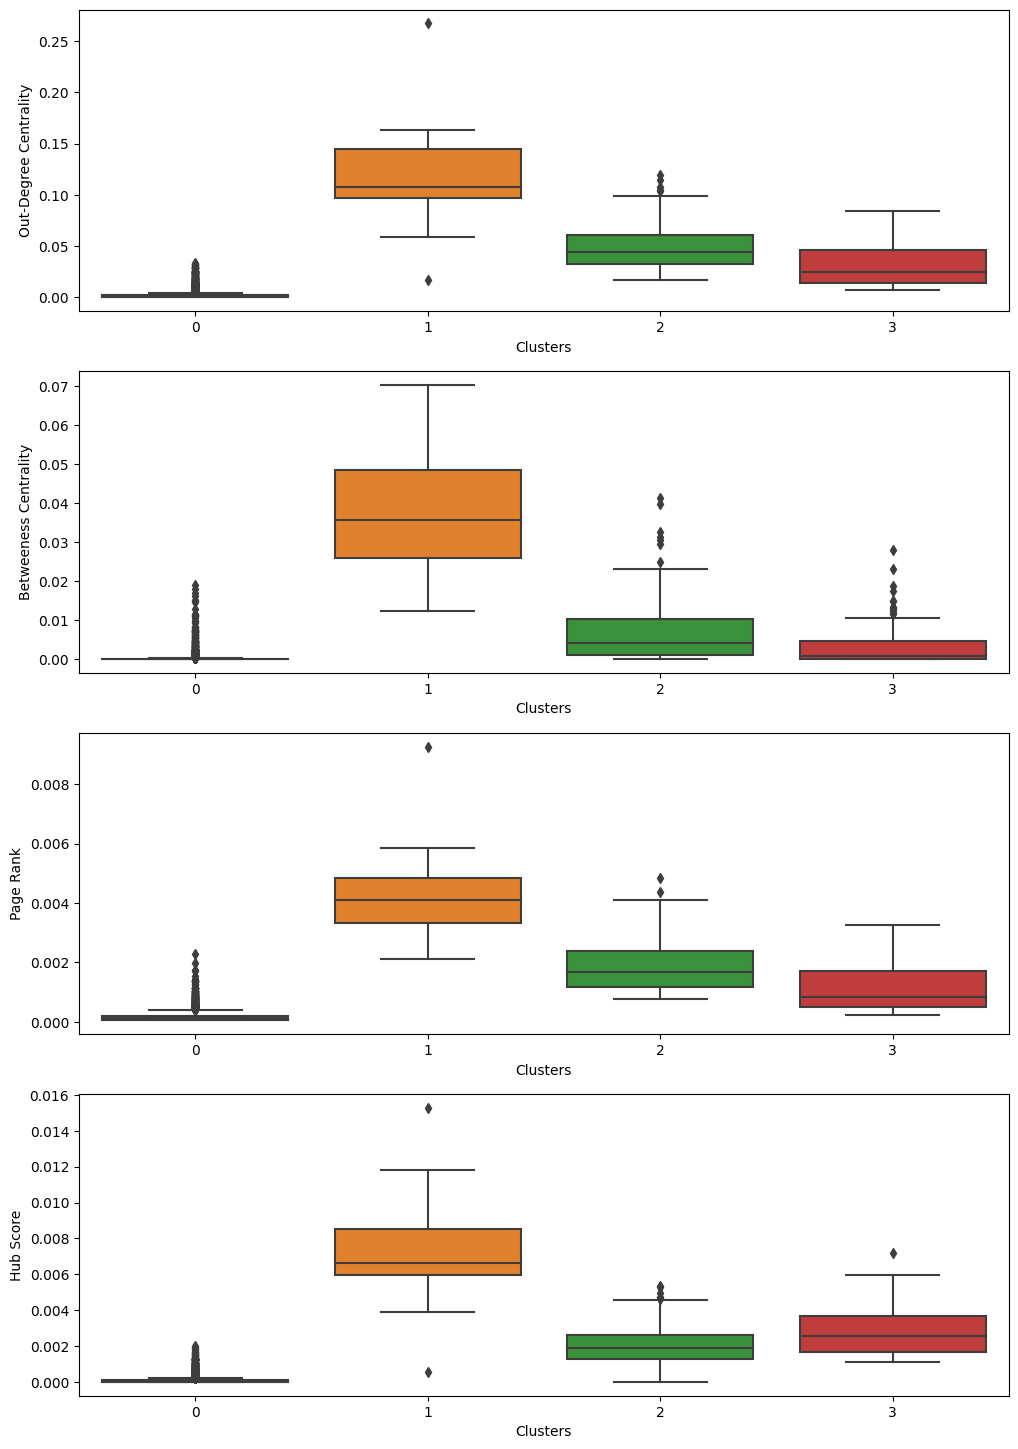

In [12]:
plt.subplots(3,1,figsize=(12,18))
for i in range(2,6):
    plt.subplot(4,1,i-1)
    sns.boxplot(data=X, x="Clusters", y=X.columns[i])


In [13]:
airports = pd.merge(left=nodes_df, right=X[["Clusters"]], how="inner", left_index=True, right_index=True)
airports = airports.drop(["Total Degree"], axis=1)

## Cluster 0
#### Cluster that represents most of the airports.

,In-Degree,Out-Degree,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
count,3209.000000,3209.000000,3209.000000,3209.000000,3.209000e+03,3209.000000,3.209000e+03,3.209000e+03
mean,9.231225,9.211592,0.002696,0.002690,3.203471e-04,0.000186,1.156660e-04,1.161535e-04
std,15.661857,15.648506,0.004574,0.004570,1.292517e-03,0.000199,2.481349e-04,2.487081e-04
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000044,-4.487729e-21,-3.959912e-19
25%,2.000000,2.000000,0.000584,0.000584,0.000000e+00,0.000076,1.618170e-06,1.594127e-06
50%,3.000000,3.000000,0.000876,0.000876,5.499202e-08,0.000119,1.888572e-05,1.918095e-05
75%,9.000000,8.000000,0.002629,0.002336,4.495050e-05,0.000206,9.221469e-05,9.264937e-05
max,118.000000,115.000000,0.034463,0.033586,1.885120e-02,0.002277,2.005405e-03,2.028184e-03


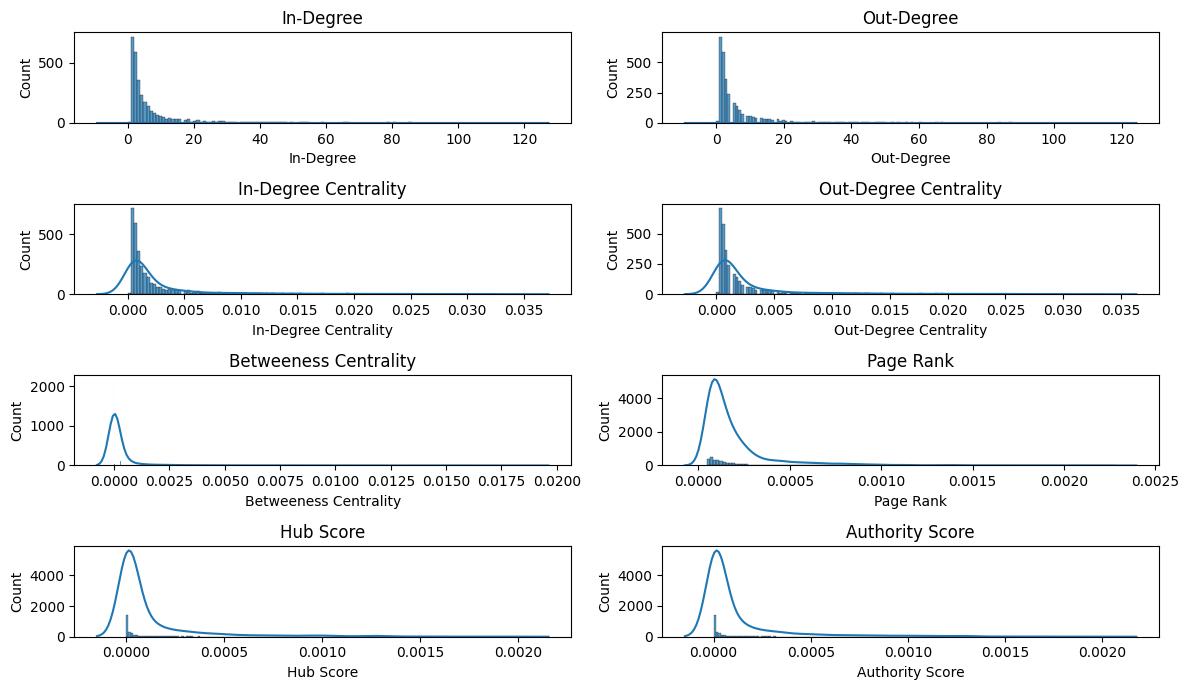

In [14]:
X_0 = airports[airports["Clusters"]==0].drop("Clusters", axis=1)
display(X_0.describe())
plt.subplots(4,2,figsize=(12,7))
for i in range(1,9):
    plt.subplot(4,2,i)
    sns.histplot(data=X_0, x=X_0.columns[i])
    sns.kdeplot(data=X_0, x=X_0.columns[i])
    plt.title(X_0.columns[i])
plt.tight_layout()
plt.show()


In [15]:
airports_info = pd.read_csv("airport - airport.csv")
airports_iata = {}
airports_icao = {}
for i in airports_info.index :
    airports_iata[airports_info["IATA"].iloc[i]] = [airports_info["City"].iloc[i],airports_info["Latitude"].iloc[i], airports_info["Longitude"].iloc[i], airports_info["Country"].iloc[i] ]
    airports_icao[airports_info["ICAO"].iloc[i]] = [airports_info["City"].iloc[i],airports_info["Latitude"].iloc[i], airports_info["Longitude"].iloc[i], airports_info["Country"].iloc[i] ]
def airport_indormation(x):
    try:
        return airports_iata[x]
    except:
        try:
            return airports_icao[x]
        except: 
            return "NNNN"

X_0["City"] = X_0["Nodes"].apply(lambda x: airport_indormation(x)[0])
X_0["Latitude"] = X_0["Nodes"].apply(lambda x: airport_indormation(x)[1])
X_0["Longitude"] = X_0["Nodes"].apply(lambda x: airport_indormation(x)[2])
X_0["Country"] = X_0["Nodes"].apply(lambda x: airport_indormation(x)[3])

In [16]:
X_0_exclude = X_0[X_0["Country"] == "N"] 
X_0_exclude["City"].value_counts()

City
N    163
Name: count, dtype: int64

The airport dataset does not have the values of all the ICAO and IATA codes of the airports. So, I have decided to exclude them. However, it should be noted this might cause under-representation of certain types of airports. 

In [17]:
X_0 = X_0[X_0["Country"] != "N"] 

In [18]:
# Create a base map
map = folium.Map(zoom_start=6)


for i in range(0,len(X_0)):
    Circle(
        location=[X_0.iloc[i]['Latitude'], X_0.iloc[i]['Longitude']],
        radius=3,
        color='red').add_to(map)

map

The Cluster 0 resembles majority of the airports and there are no distinct patterns/clusters that could be visulaized on it.

## Cluster 1

,In-Degree,Out-Degree,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,408.217391,408.782609,0.119222,0.119387,0.038075,0.004236,0.007298,0.007305
std,162.120313,163.567044,0.047348,0.047771,0.016016,0.001483,0.003067,0.003043
min,59.000000,59.000000,0.017231,0.017231,0.012168,0.002120,0.000545,0.000543
25%,331.000000,330.500000,0.096671,0.096525,0.025968,0.003329,0.005937,0.005909
50%,374.000000,370.000000,0.109229,0.108061,0.035558,0.004111,0.006644,0.006619
75%,495.500000,494.500000,0.144714,0.144422,0.048299,0.004839,0.008509,0.008468
max,911.000000,915.000000,0.266063,0.267231,0.070204,0.009263,0.015264,0.015144


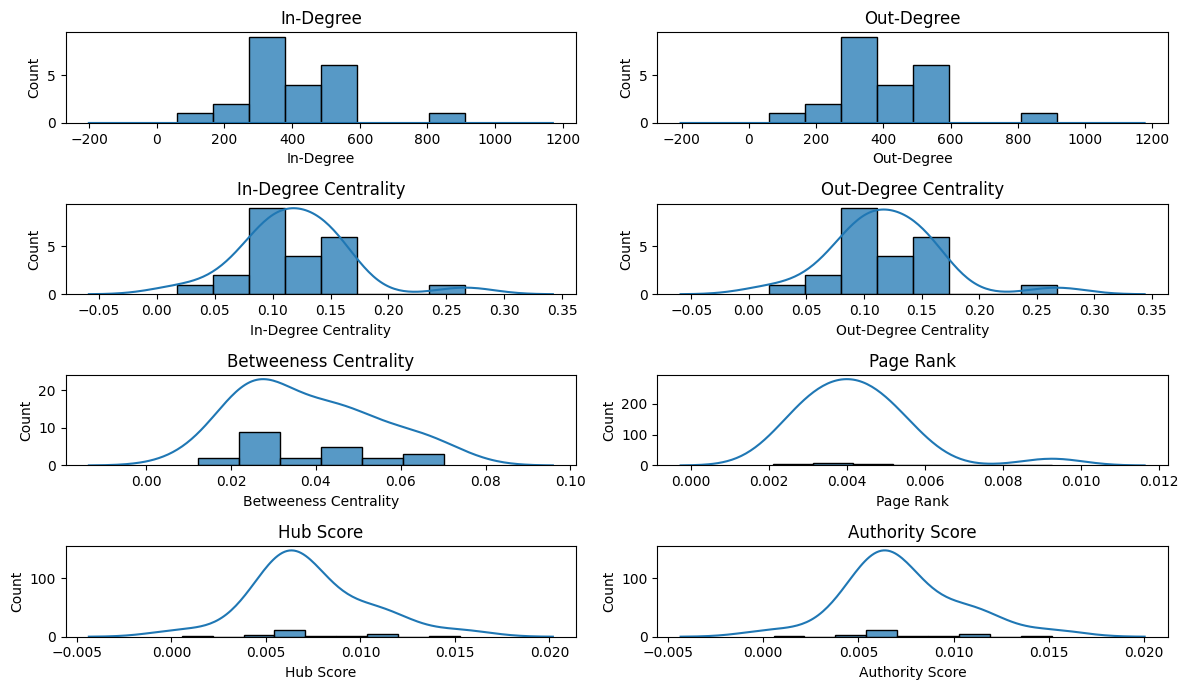

In [19]:
X_1 = airports[airports["Clusters"]==1].drop("Clusters", axis=1)
display(X_1.describe())
plt.subplots(4,2,figsize=(12,7))
for i in range(1,9):
    plt.subplot(4,2,i)
    sns.histplot(data=X_1, x=X_1.columns[i])
    sns.kdeplot(data=X_1, x=X_1.columns[i])
    plt.title(X_1.columns[i])
plt.tight_layout()
plt.show()


In [20]:
X_1["City"] = X_1["Nodes"].apply(lambda x: airport_indormation(x)[0])
X_1["Latitude"] = X_1["Nodes"].apply(lambda x: airport_indormation(x)[1])
X_1["Longitude"] = X_1["Nodes"].apply(lambda x: airport_indormation(x)[2])
X_1["Country"] = X_1["Nodes"].apply(lambda x: airport_indormation(x)[3])

In [21]:
# Create a base map
map = folium.Map(zoom_start=6)


for i in range(0,len(X_1)):
    Circle(
        location=[X_1.iloc[i]['Latitude'], X_1.iloc[i]['Longitude']],
        radius=3,
        color='red').add_to(map)

map

The airports belonging to cluster 1 represent airports which are highly important. An interesting inference from the above visualization is that we can see that aiports is that these are somewhat equally distributed across North America, Europe and Asia.

## Cluster 2

,In-Degree,Out-Degree,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,174.307018,174.350877,0.050907,0.050920,0.007492,0.001870,0.002067,0.002067
std,80.450625,80.717028,0.023496,0.023574,0.008767,0.000866,0.001219,0.001214
min,57.000000,57.000000,0.016647,0.016647,0.000040,0.000780,0.000015,0.000022
25%,113.250000,110.750000,0.033075,0.032345,0.001113,0.001164,0.001295,0.001289
50%,152.500000,152.000000,0.044539,0.044393,0.004114,0.001672,0.001874,0.001892
75%,209.000000,208.000000,0.061040,0.060748,0.010289,0.002391,0.002624,0.002647
max,412.000000,408.000000,0.120327,0.119159,0.041219,0.004829,0.005379,0.005335


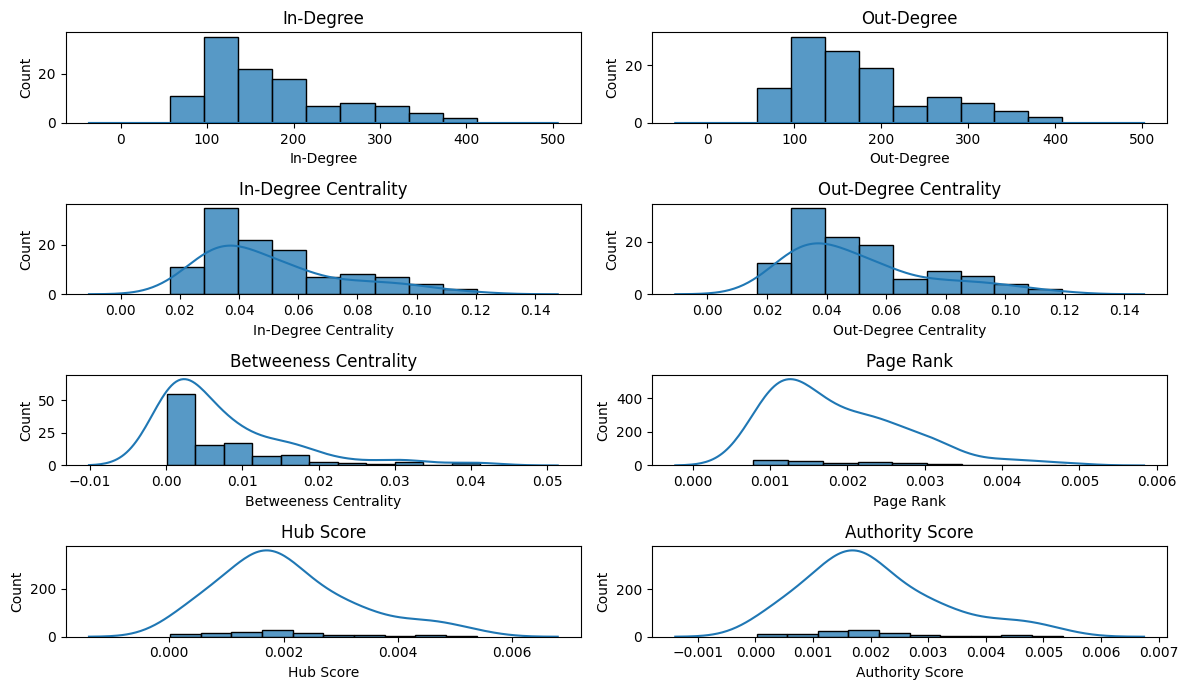

In [22]:
X_2 = airports[airports["Clusters"]==2].drop("Clusters", axis=1)
display(X_2.describe())
plt.subplots(4,2,figsize=(12,7))
for i in range(1,9):
    plt.subplot(4,2,i)
    sns.histplot(data=X_2, x=X_2.columns[i])
    sns.kdeplot(data=X_2, x=X_2.columns[i])
    plt.title(X_2.columns[i])
plt.tight_layout()
plt.show()

In [23]:
X_2["City"] = X_2["Nodes"].apply(lambda x: airport_indormation(x)[0])
X_2["Latitude"] = X_2["Nodes"].apply(lambda x: airport_indormation(x)[1])
X_2["Longitude"] = X_2["Nodes"].apply(lambda x: airport_indormation(x)[2])
X_2["Country"] = X_2["Nodes"].apply(lambda x: airport_indormation(x)[3])

## Cluster 3

,In-Degree,Out-Degree,In-Degree Centrality,Out-Degree Centrality,Betweeness Centrality,Page Rank,Hub Score,Authority Score
count,79.000000,79.000000,79.000000,79.000000,7.900000e+01,79.000000,79.000000,79.000000
mean,111.139241,111.708861,0.032459,0.032625,3.796213e-03,0.001168,0.002852,0.002831
std,74.052603,73.920982,0.021628,0.021589,5.987365e-03,0.000801,0.001418,0.001423
min,23.000000,23.000000,0.006717,0.006717,7.733289e-08,0.000244,0.001105,0.001106
25%,45.000000,46.500000,0.013143,0.013581,5.148733e-05,0.000498,0.001665,0.001660
50%,84.000000,83.000000,0.024533,0.024241,8.380052e-04,0.000831,0.002554,0.002462
75%,159.500000,158.500000,0.046583,0.046291,4.522840e-03,0.001720,0.003674,0.003654
max,287.000000,289.000000,0.083820,0.084404,2.802497e-02,0.003256,0.007188,0.007060


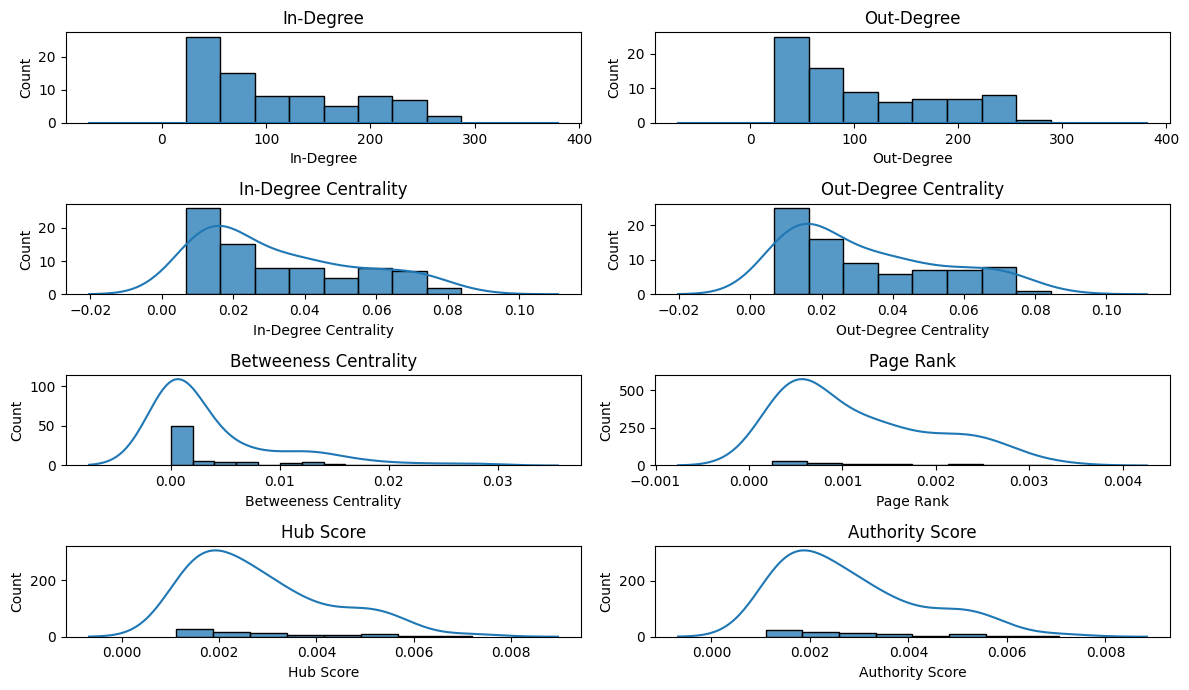

In [24]:
X_3 = airports[airports["Clusters"]==3].drop("Clusters", axis=1)
display(X_3.describe())
plt.subplots(4,2,figsize=(12,7))
for i in range(1,9):
    plt.subplot(4,2,i)
    sns.histplot(data=X_3, x=X_3.columns[i])
    sns.kdeplot(data=X_3, x=X_3.columns[i])
    plt.title(X_3.columns[i])
plt.tight_layout()
plt.show()

In [25]:
X_3["City"] = X_3["Nodes"].apply(lambda x: airport_indormation(x)[0])
X_3["Latitude"] = X_3["Nodes"].apply(lambda x: airport_indormation(x)[1])
X_3["Longitude"] = X_3["Nodes"].apply(lambda x: airport_indormation(x)[2])
X_3["Country"] = X_3["Nodes"].apply(lambda x: airport_indormation(x)[3])

## Cluster 2 and 3 Airports Distribution on Map

In [26]:
# Create a base map
map = folium.Map(zoom_start=6)


for i in range(0,len(X_2)):
    Circle(
        location=[X_2.iloc[i]['Latitude'], X_2.iloc[i]['Longitude']],
        radius=3,
        color='red').add_to(map)

for i in range(0,len(X_3)):
    Circle(
        location=[X_3.iloc[i]['Latitude'], X_3.iloc[i]['Longitude']],
        radius=3,
        color='purple').add_to(map) 
         
map

Red dots represent airports which belong to Cluster 2 and Purple dots represent airports belong to cluster 3. The visualization represents some interesting inferences. The airports belonging to cluster 2 have all node importance metrics(except hub and authority scores) higher that of the airports belonging to cluster 3. The airports belonging to cluster to are localized in areas apart from the United States, whereas the airports in cluster 3 are localized within the United States.


# Summary

1) Constructed a Network Edge Dataset from an Airline_Network Dataset.

2) Engineered Node Importance Features.

3) Used K-Means to distinguis Airports into 4 main Categories.

    Cluster 0: Not so important airports.

    Cluster 1: Very Important Airports.

    Cluster 2: Less Impoertant than Cluster 1 but more than Cluster 0. Not as good Hub or Authorties as Cluster 3. Aiports belonging to these clusters seem to be outside of United States.

    Cluster 3: Less Impoertant than Cluster 1 but more than Cluster 0. On average, shows lower Degree Centrality, Betweeness Centrality and Page Rank than Cluster 2. Also, identified that these kinds of airports are typically located in the United States.